In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import imageio
from idx_tools import Idx
import os

%matplotlib inline 

In [2]:
def convert_image(img, blur=3):
    # Convert to grayscale
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding to binarize the image
    conv_img = cv2.adaptiveThreshold(conv_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)

    # Blur the image to reduce noise
    conv_img = cv2.medianBlur(conv_img, blur)
    
    return conv_img

In [3]:
def extract_char(conv_img):
    # Find contours
    _, ctrs, _ = cv2.findContours(conv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours
    return sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

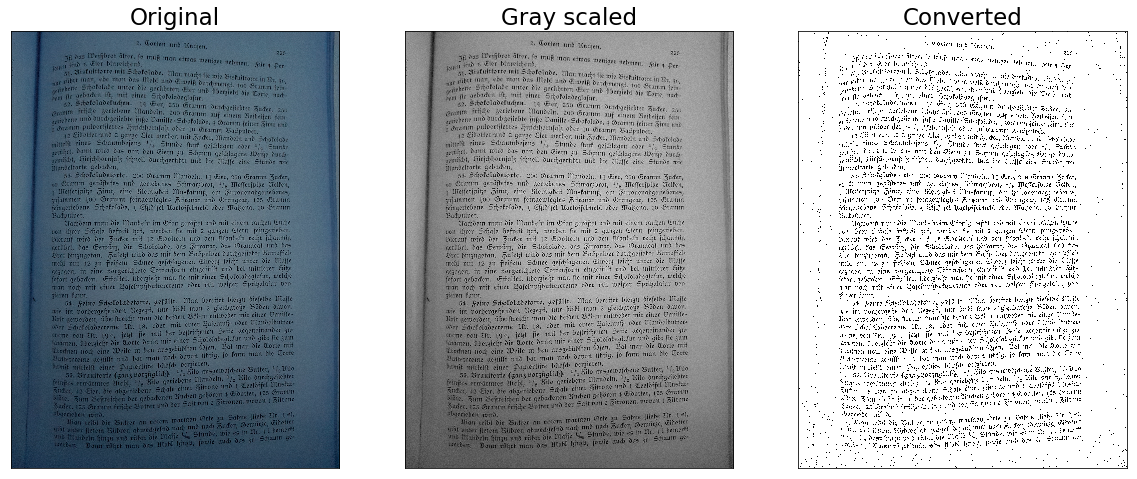

In [27]:
# Read image
img = cv2.imread('./images/01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
conv_img = convert_image(img)

# Show the effects of each processing stage
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

cmaps = ['jet', 'gray', 'gray']
titles = ['Original', 'Gray scaled', 'Converted']
data = [img, gray, conv_img]
for i in range(3):
    ax[i].imshow(data[i], cmap=cmaps[i])
    ax[i].set_title(titles[i], fontsize=23)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

In [5]:
def save_char(sorted_ctrs, img, lower=600, upper=20000, path='./char'):
    
    # Create the target folder for saving the extracted images
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Convert original image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Number of images already in the target folder
    n = len(os.listdir('./char')) + 1
    
    # Number of potential characters found in the image
    n_char = np.shape(sorted_ctrs)[0]
    
    # Go through each potential character
    for i in range(n_char):
        
        # Get coordinates of the potential character
        x, y, w, h = cv2.boundingRect(sorted_ctrs[i])
        
        # Test if the number of pixels in the bounding box is reasonable
        if (w * h) > lower and (w * h) < upper:
            
            # Draw the bounding box in the original image
            result = cv2.rectangle(img, (x, y), ( x + w, y + h ), (0, 255, 0), 2)

            # Extract the character and save it as a .jpeg
            roi = gray[y:y+h, x:x+w]
            imageio.imwrite('{}/char_{}.jpg'.format(path, n), roi)
            
            # Increase counter
            n += 1
    
    # Return image with all bounding boxes
    return result

In [6]:
# List of all images to create the first training data 
image_files = ['./images/01.jpg',
          './images/02.jpg',
          './images/03.jpg',
          './images/04.jpg']

# Go through all files and extract the characters
for file in image_files:

    # Read image
    img = cv2.imread(file)

    # Convert the image (gray/thresholded/blured)
    conv_img = convert_image(img)

    # Find and sort the contours
    sorted_ctrs = extract_char(conv_img)

    # Save the result
    result = save_char(sorted_ctrs, img)

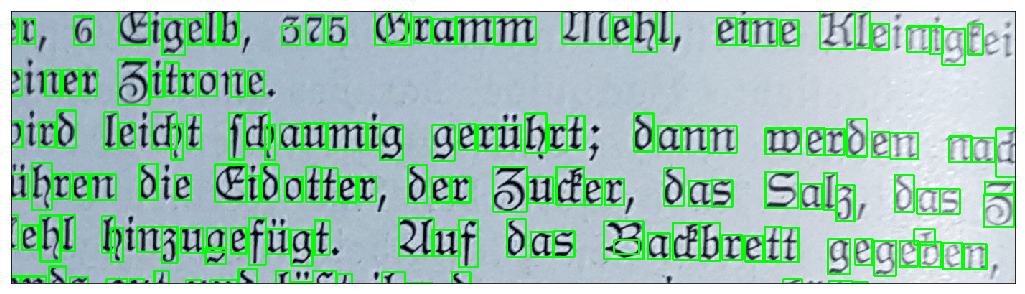

In [7]:
# Lets look at the result
fig, ax = plt.subplots(1, 1, figsize=(18, 32))

ax.imshow(result)
ax.set_xlim([1000, 2400])
ax.set_ylim([1800, 1420])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [9]:
data_path = './char/'
convSize = [80, 80]

files = [data_path + x for x in os.listdir(data_path)]

images = []
for file in files:
    img = cv2.imread(file)[:, :, 0]
    img = cv2.resize(img, (convSize[0], convSize[1]))
    img = img.reshape(convSize[0] * convSize[1])
    images.append(img)
    
images = np.array(images, dtype='float64')

In [10]:
scaler = StandardScaler()
scaler.fit(images)
scaled = scaler.transform(images)

pca = PCA(n_components=25)
pca.fit(scaled)
pca_img = pca.transform(scaled)

In [14]:
# German alphabet 26 letters + 4 special = 30 letters in total
nClusters = 100

kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(pca_img)

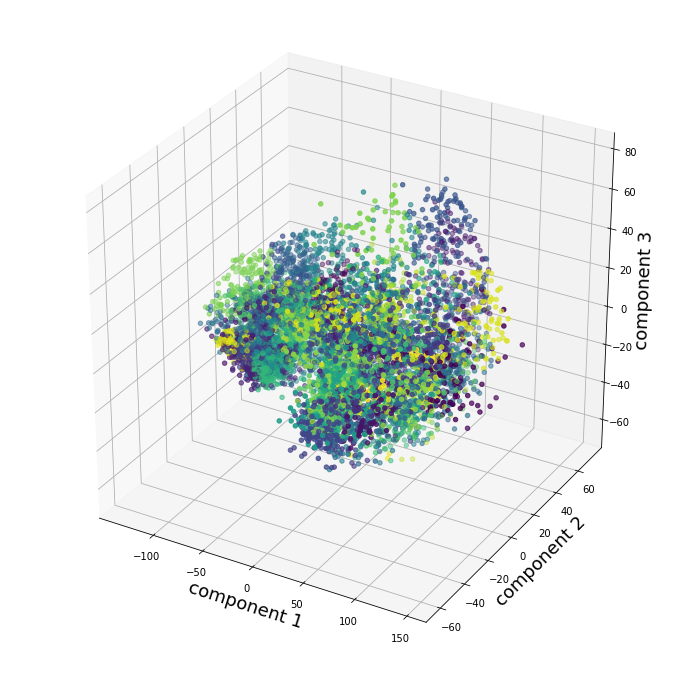

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(pca_img[:, 0], pca_img[:, 1], pca_img[:, 2], c=kmeans.labels_)

ax.set_xlabel('component 1', fontsize=18)
ax.set_ylabel('component 2', fontsize=18)
ax.set_zlabel('component 3', fontsize=18)

plt.show()

In [16]:
path = './clustered'

if not os.path.isdir(path):
    os.mkdir(path)

n = 0
for i in range(kmeans.labels_.max()):
    
    cluster_path = '{}/{}'.format(path, i)
    
    if not os.path.isdir(cluster_path):
        os.mkdir(cluster_path)
    
    tmp = images[kmeans.labels_ == kmeans.labels_[i]]
    
    for j in range(np.shape(tmp)[0]):
        tmpImg = np.reshape(tmp[j], convSize).astype(np.uint8)
        imageio.imwrite('{}/{}.jpg'.format(cluster_path, n), tmpImg)
        n += 1
        
# Delete the un-clustered data
[os.remove(data_path + x) for x in os.listdir(data_path)]
os.rmdir(data_path)

In [2]:
# Where is the sorted data located?
dataset_path = './data/' 

# Where should the converted data be stored?
dest_folder = './dataset/' 

# What is the ratio of train vs. test data?
train_percent = 0.7

# Subfolders for structuring the sorted data
train_path = dataset_path + 'train/'
test_path = dataset_path + 'test/'

# Find all folders in the sorted data
folders = os.listdir(dataset_path)

# Create folders
if not os.path.isdir(train_path):
    os.mkdir(train_path)
    os.mkdir(test_path)
    
if not os.path.isdir(dest_folder):
    os.mkdir(dest_folder)
    
# Go through all folders in the sorted data and split into train and test    
for char in folders:
    char_path = dataset_path + char + '/'
    train_folder = train_path + char + '/'
    test_folder = test_path + char + '/'
    
    samples = os.listdir(char_path)
    n_samples = len(samples)
    n_train = round(train_percent * n_samples)
    
    sel = np.arange(n_samples)
    np.random.shuffle(sel)
    
    idx_train = sel[0:n_train] 
    idx_test = sel[n_train:]
    
    if not os.path.isdir(train_folder):
        os.mkdir(train_folder)
        
    if not os.path.isdir(test_folder):
        os.mkdir(test_folder)
    
    [os.rename(char_path + samples[x], train_folder + samples[x]) for x in idx_train]
    [os.rename(char_path + samples[x], test_folder + samples[x]) for x in idx_test]
    
    os.rmdir(char_path)
    
# Convert data to idx format    
Idx.save_idx(train_path)
Idx.save_idx(test_path)

# Move converted dataset to target folder
os.rename(train_path + 'images.idx3-ubyte', dest_folder + 'train-images.idx3-ubyte')
os.rename(train_path + 'labels.idx3-ubyte', dest_folder + 'train-labels.idx3-ubyte')
os.rename(test_path + 'images.idx3-ubyte', dest_folder + 'test-images.idx3-ubyte')
os.rename(test_path + 'labels.idx3-ubyte', dest_folder + 'test-labels.idx3-ubyte')

In [ ]:
CREATE .TXT FILE WITH ALL FOLDER NAMES